In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import pickle
import warnings
warnings.filterwarnings("ignore")
sns.set()

In [2]:
df = pd.read_pickle('L_Prep_State')
df.STATE = df.STATE.replace({'norm': 0, 'AC': 1, 'SCC': 2})
df.head()

,A1BG,A1CF,A2M,A2ML1,A4GALT,A4GNT,AAAS,AACS,AADAC,AADACL2,...,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,STATE
GTEX-111CU,6.282829,0.187227,16.459309,1.390586,9.284774,1.817905,8.861321,9.356633,7.162157,0.405928,...,6.51922,5.774152,8.752136,10.276568,0.395912,9.567469,13.064981,10.710016,9.178765,0
GTEX-111FC,6.459492,0.386816,16.357314,1.462766,8.363233,2.132,9.006019,8.859413,6.86954,0.912104,...,6.3021,5.82059,8.343859,10.116765,0.997971,9.816011,12.760873,10.042366,9.167625,0
GTEX-111VG,7.143432,-0.003366,17.293667,3.257567,9.789358,1.98931,9.090267,9.029279,6.511335,2.000838,...,5.736464,5.852467,8.692399,9.894538,1.543979,9.80994,13.636654,10.698651,8.804904,0
GTEX-111YS,6.464637,0.061339,15.854521,1.953561,8.419853,1.315828,8.923156,9.24981,9.213866,0.004093,...,6.219143,5.812366,8.67694,10.376354,0.589715,10.132188,12.351264,10.884633,9.129941,0
GTEX-1122O,6.826894,-0.094578,16.039283,2.107355,8.505655,2.619394,9.076225,9.249061,8.817053,-0.682806,...,6.624728,5.650416,8.57541,10.407757,1.191774,9.888598,12.661172,10.8646,8.97088,0


In [3]:
X = df.drop('STATE', axis=1)
y = df.STATE

### 1. Dropping Constant Features

In [4]:
from sklearn.feature_selection import VarianceThreshold
gens_var = VarianceThreshold(threshold=0.01)
gens_var.fit(X)
constant_gens = [col for col in X.columns if col not in X.columns[gens_var.get_support()]]
len(constant_gens) # 0.01/271

271

So we can confidently drop constant_gens from our dataset.

In [5]:
X = X.drop(constant_gens, axis=1) # (1706, 17289)   ## 17648 - 326 = 17322
X.shape # (1706, 17322)

(1706, 17322)

### 2. Dropping Features with Correlation

In [13]:
def correlation(data, threshold):
    col_corr = set()
    corr_matrix = data.corr()
    k = 1
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                col_corr.add(corr_matrix.columns[i])
        if i // 200 == k:
            print(f'i = {i},   number of features = {len(col_corr)}')
            k += 1
    return col_corr

In [26]:
# It runs for more than an hour, so run it ONLY ONCE and then use the next cell for loading the results instead of using this cell
corr_features = correlation(X, 0.9)
len(corr_features), len(set(corr_features)) # 583
with open('corr_genes.pkl', 'wb') as file:
    pickle.dump(corr_features, file)

i = 200,   number of features = 4
i = 400,   number of features = 8
i = 600,   number of features = 10
i = 800,   number of features = 13
i = 1000,   number of features = 18
i = 1200,   number of features = 22
i = 1400,   number of features = 25
i = 1600,   number of features = 34
i = 1800,   number of features = 45
i = 2000,   number of features = 50
i = 2200,   number of features = 53
i = 2400,   number of features = 64
i = 2600,   number of features = 92
i = 2800,   number of features = 104
i = 3000,   number of features = 113
i = 3200,   number of features = 123
i = 3400,   number of features = 125
i = 3600,   number of features = 127
i = 3800,   number of features = 129
i = 4000,   number of features = 135
i = 4200,   number of features = 148
i = 4400,   number of features = 159
i = 4600,   number of features = 164
i = 4800,   number of features = 176
i = 5000,   number of features = 185
i = 5200,   number of features = 195
i = 5400,   number of features = 205
i = 5600,   number o

(583, 583)

In [7]:
with open('corr_genes.pkl', 'rb') as file:
    corr_features = pickle.load(file)
len(corr_features)  # 583

583

In [8]:
X = X.drop(corr_features, axis=1) # (1706, ????)
X.shape # (1706, 16739)

(1706, 16739)

So now we have constant_gens (271) and corr_features (583) that we can remove from our dataset:
17593 - (271 + 583) = 16739, but it's still too much...

In [32]:
X.to_csv('X_corr.csv', index=False)

### 3. Selecting Features Using Information Gain for Classification

In [33]:
from sklearn.feature_selection import mutual_info_classif
mutual_info = pd.Series(mutual_info_classif(X, y))
mutual_info.index = X.columns
mutual_info.sort_values(ascending=False).head()

KRT74     0.774049
DSG3      0.721880
CALML3    0.704262
SLC2A1    0.697846
KRT31     0.695466
dtype: float64

In [34]:
best_MI_State = mutual_info.sort_values(ascending=False).head(30).index
best_MI_State

Index(['KRT74', 'DSG3', 'CALML3', 'SLC2A1', 'KRT31', 'ARRB1', 'KRT33A',
       'FAM83B', 'HOXD11', 'WWC2', 'TMPRSS11A', 'FAM83C', 'TMPRSS11F',
       'C10orf99', 'RAET1L', 'KRT9', 'FERMT1', 'GABRQ', 'FAM131C', 'C1orf74',
       'LIMCH1', 'TPRXL', 'GRHL3', 'STX11', 'DLX6', 'SPRR4', 'CD302',
       'SLC6A10P', 'KRT77', 'TMEM79'],
      dtype='object')

### 4. Selecting Features Using ANOVA Statistical Analysis

In [35]:
gens_with_negative_values = X.columns[(X < 0).any()].tolist()
len(gens_with_negative_values) # 3258

3258

So we can't use Chi2 test, but we can try ANOVA.

In [36]:
from sklearn.feature_selection import f_classif, SelectPercentile, SelectKBest
f_values, p_values = f_classif(X, y)
p_values = pd.Series(p_values, index=X.columns)

In [37]:
sel_30_cols = SelectKBest(f_classif, k=30)
sel_30_cols.fit(X, y)
best_ANOVA_State = X.columns[sel_30_cols.get_support()]
best_ANOVA_State

Index(['ADRA1A', 'AMIGO3', 'ANGPT4', 'ANGPTL7', 'ANLN', 'ARRB1', 'ASPA',
       'C10orf67', 'CALML3', 'CAT', 'CAV1', 'CD5L', 'DSG3', 'EFNA3', 'EMP2',
       'GPD1', 'GPR146', 'GYPE', 'ITLN2', 'LMO7', 'MYOC', 'PERP', 'PTPN21',
       'PYCR1', 'RTKN2', 'SCUBE1', 'SLC2A1', 'SLC6A4', 'STX11', 'WWC2'],
      dtype='object')

In [39]:
len(set(best_MI_State) & set(best_ANOVA_State))

6

### 5. Selecting Features Using Feature Importance

In [40]:
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier()
model.fit(X, y)

ExtraTreesClassifier()

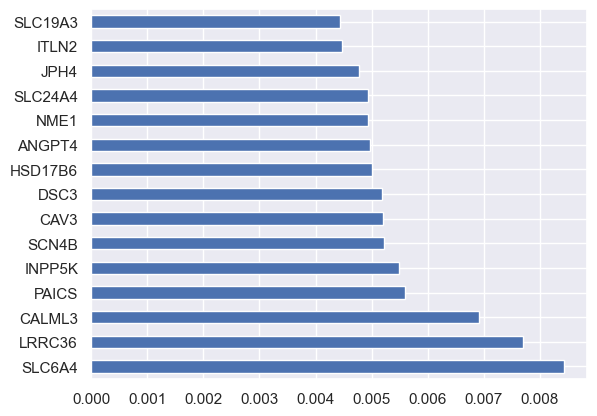

In [47]:
ranked_features = pd.Series(model.feature_importances_, index= X.columns)
best_TreesClass = ranked_features.nlargest(15).index
ranked_features.nlargest(15).plot(kind='barh');

In [58]:
st1 = set(set(best_MI_State) & set(best_ANOVA_State)) # 6    {'ARRB1', 'CALML3', 'DSG3', 'SLC2A1', 'STX11', 'WWC2'}
st2 = set(set(best_MI_State) & set(best_TreesClass)) # 1     {'CALML3'}
st3 = set(set(best_ANOVA_State) & set(best_TreesClass)) # 4  {'ANGPT4', 'CALML3', 'ITLN2', 'SLC6A4'}

{'ARRB1', 'CALML3', 'DSG3', 'SLC2A1', 'STX11', 'WWC2'}

In [60]:
standard_features = set(set(best_MI_State) | set(best_ANOVA_State) | set(best_TreesClass)) # 65
len(standard_features)

65

In [62]:
with open('standard_features.pkl', 'wb') as file:
    pickle.dump(standard_features, file)

#### **Features Visualization**

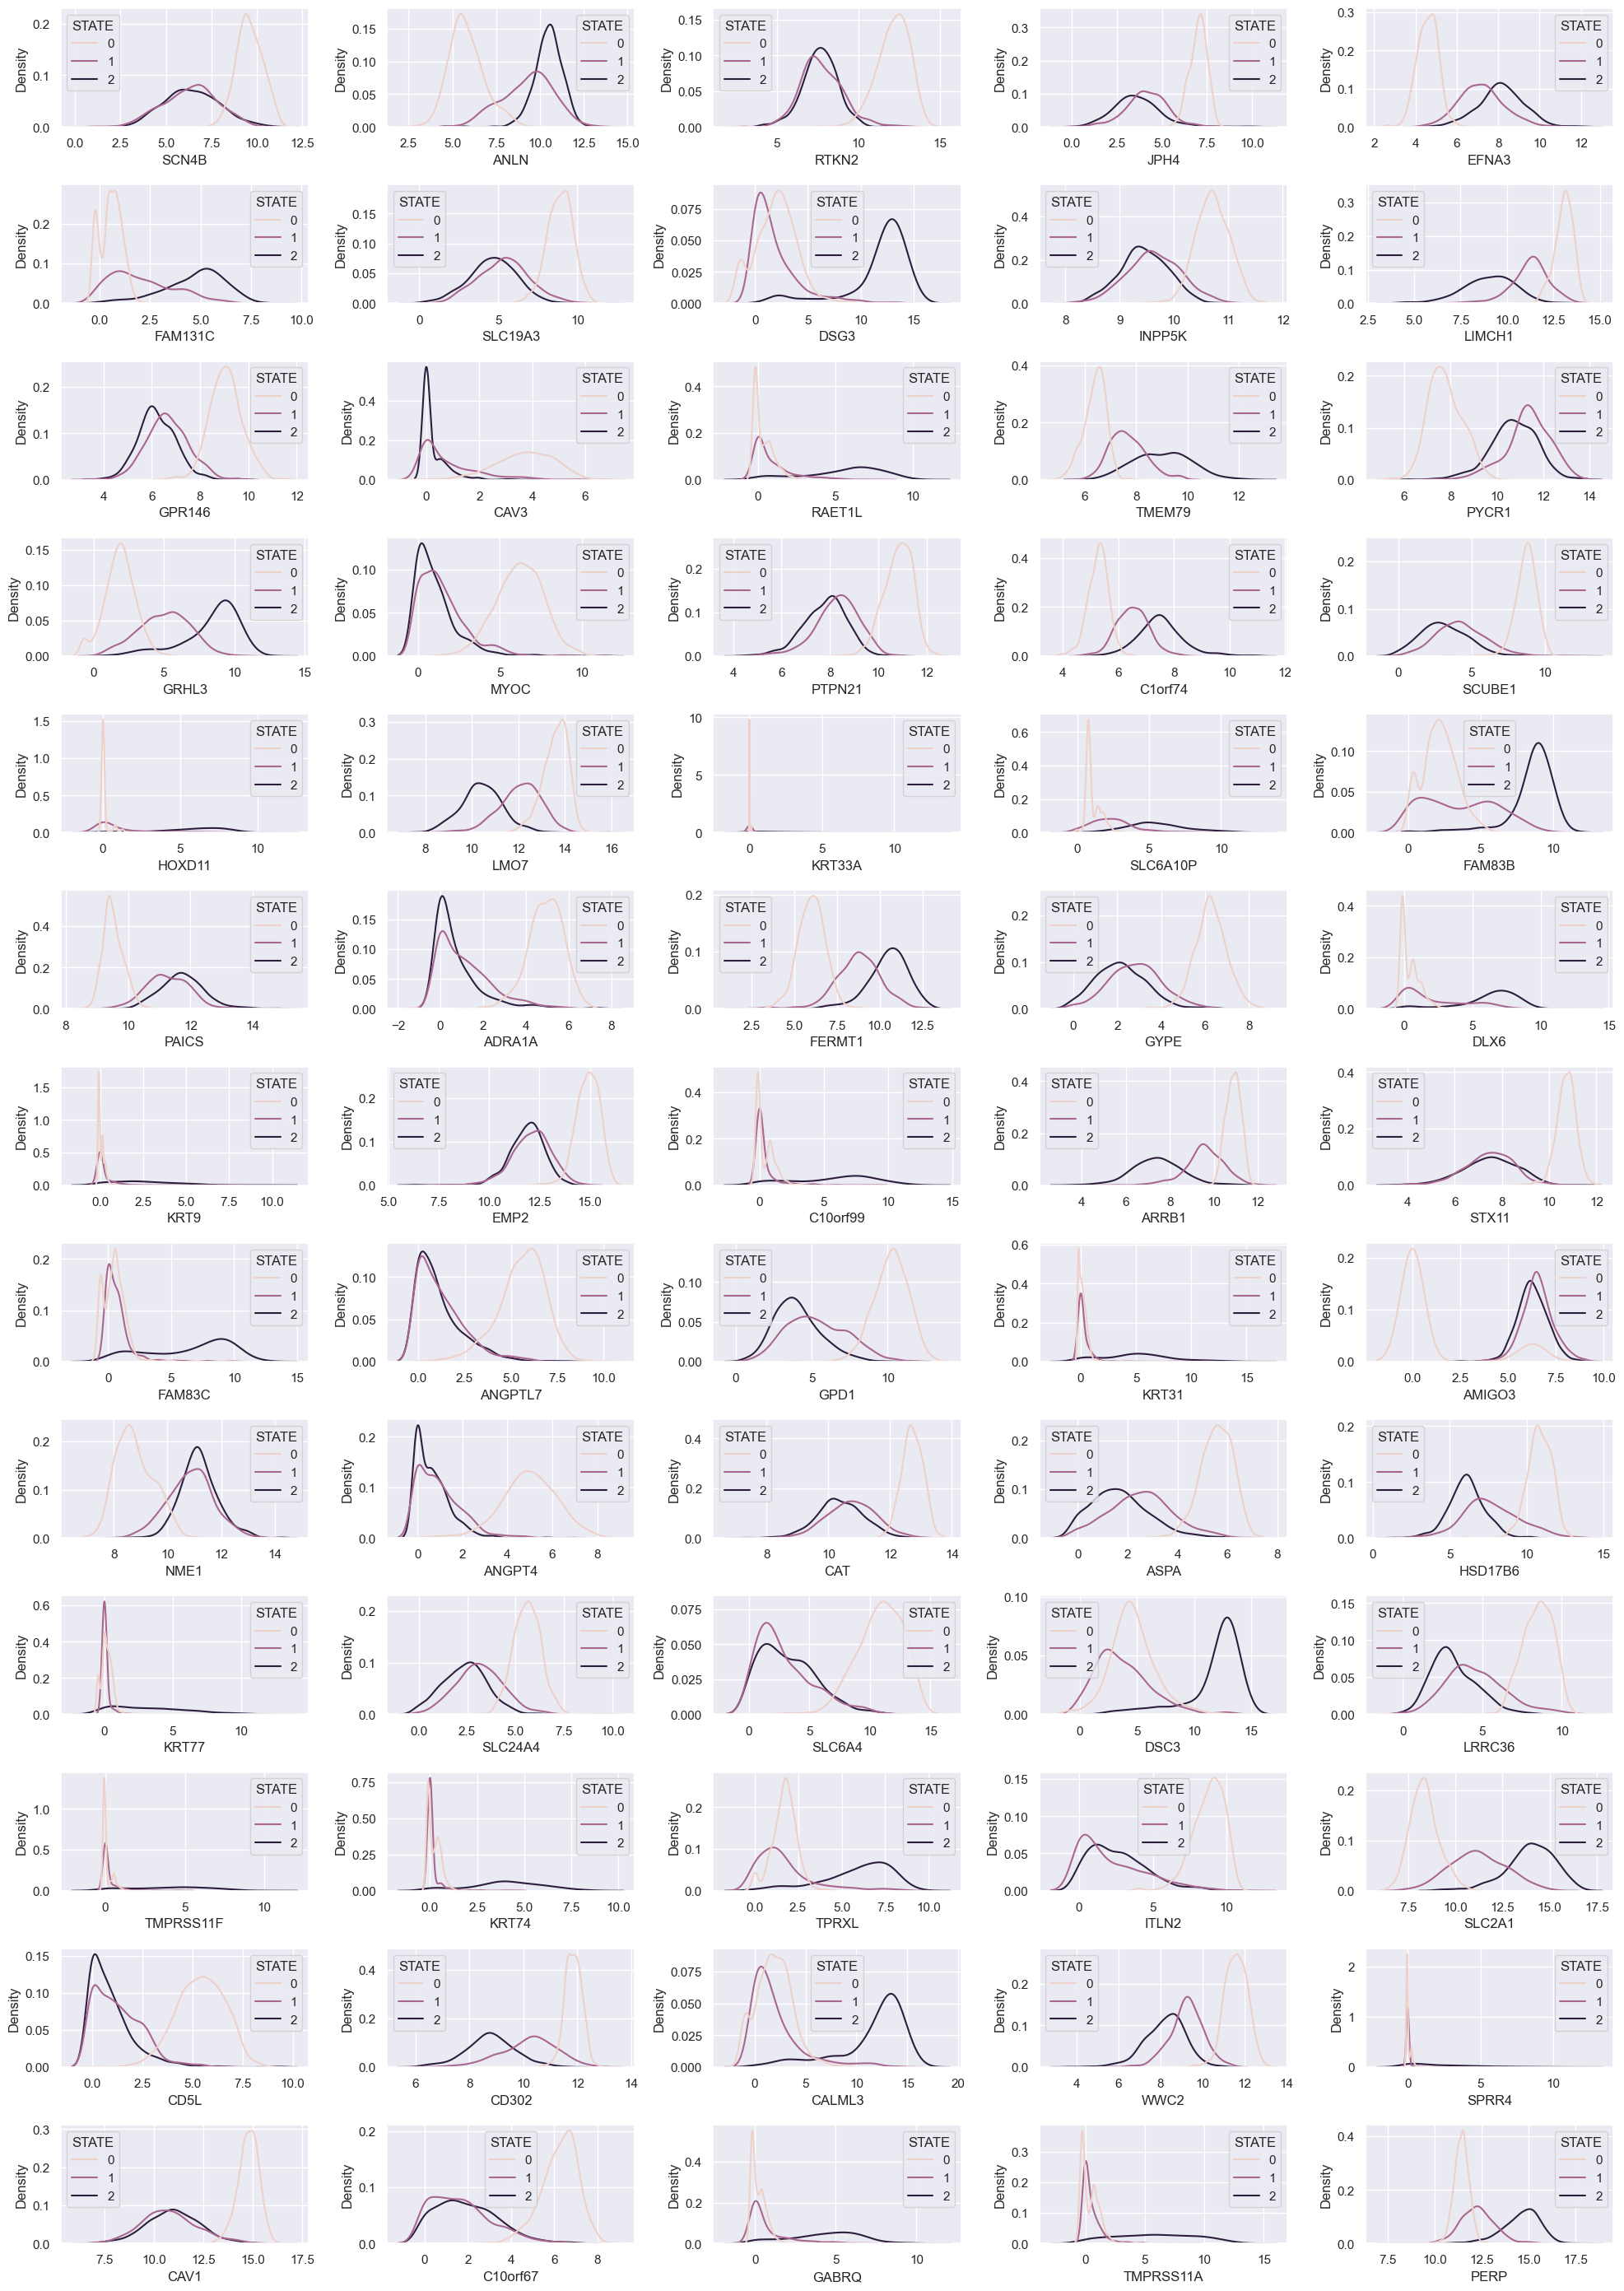

In [65]:
fig, axs = plt.subplots(13, 5, figsize=(20, 28))
i = 0
for gen in standard_features:
    sns.kdeplot(data=df, x = gen, hue='STATE', ax=axs[i//5, i%5], legend=True)
    i += 1
plt.tight_layout();

In [66]:
fig.savefig('L_Compare_Features_Standard.svg', format='svg')

As we see it is almost impossible to identify three states by any one gene - some genes are well shared for tumor-normal, and some for two kinds of tumor.

#### ***Detecting ONLY tumor***

In [38]:
# X stays the same as in the previous investigation
y_norm_tumor = y.replace({2: 1})
y_norm_tumor.value_counts()

STATE
1    1018
0     688
Name: count, dtype: int64

In [39]:
from sklearn.feature_selection import mutual_info_classif, SelectKBest
mutual_info = pd.Series(mutual_info_classif(X, y_norm_tumor))
mutual_info.index = X.columns
best10_MI_norm_tumor = mutual_info.sort_values(ascending=False).head(10).index
best10_MI_norm_tumor # ['STX11', 'EMP2', 'SDPR', 'CAV1', 'WWC2', 'CAT', 'ADPRH', 'EFNA3', 'AKAP2', 'PTPN21']

Index(['STX11', 'EMP2', 'SDPR', 'CAV1', 'WWC2', 'CAT', 'ADPRH', 'EFNA3',
       'AKAP2', 'PTPN21'],
      dtype='object')

In [53]:
from sklearn.feature_selection import f_classif
sel_10_cols = SelectKBest(f_classif, k=10)
sel_10_cols.fit(X, y_norm_tumor)
best10_ANOVA_norm_tumor = X.columns[sel_10_cols.get_support()]
best10_ANOVA_norm_tumor # ['ADRA1A', 'ANGPT4', 'C10orf67', 'CD5L', 'EMP2', 'GYPE', 'ITLN2', 'RTKN2', 'SLC6A4', 'STX11']

Index(['ADRA1A', 'ANGPT4', 'C10orf67', 'CD5L', 'EMP2', 'GYPE', 'ITLN2',
       'RTKN2', 'SLC6A4', 'STX11'],
      dtype='object')

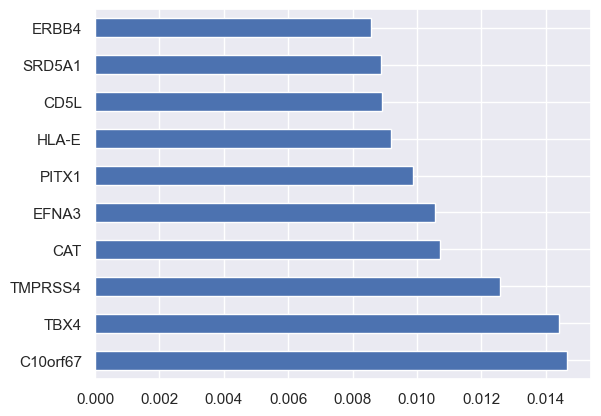

In [68]:
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier(random_state=9)
model.fit(X, y_norm_tumor)
ranked_features = pd.Series(model.feature_importances_, index=X.columns)
best10_TreesClass_norm_tumor = ranked_features.nlargest(10).index
ranked_features.nlargest(10).plot(kind='barh');

In [69]:
best_standard_norm_tumor = set(set(best10_MI_norm_tumor) | set(best10_ANOVA_norm_tumor) | set(best10_TreesClass_norm_tumor)) # 24
len(best_standard_norm_tumor)

24

In [70]:
with open('best_standard_norm_tumor.pkl', 'wb') as file:
    pickle.dump(best_standard_norm_tumor, file)

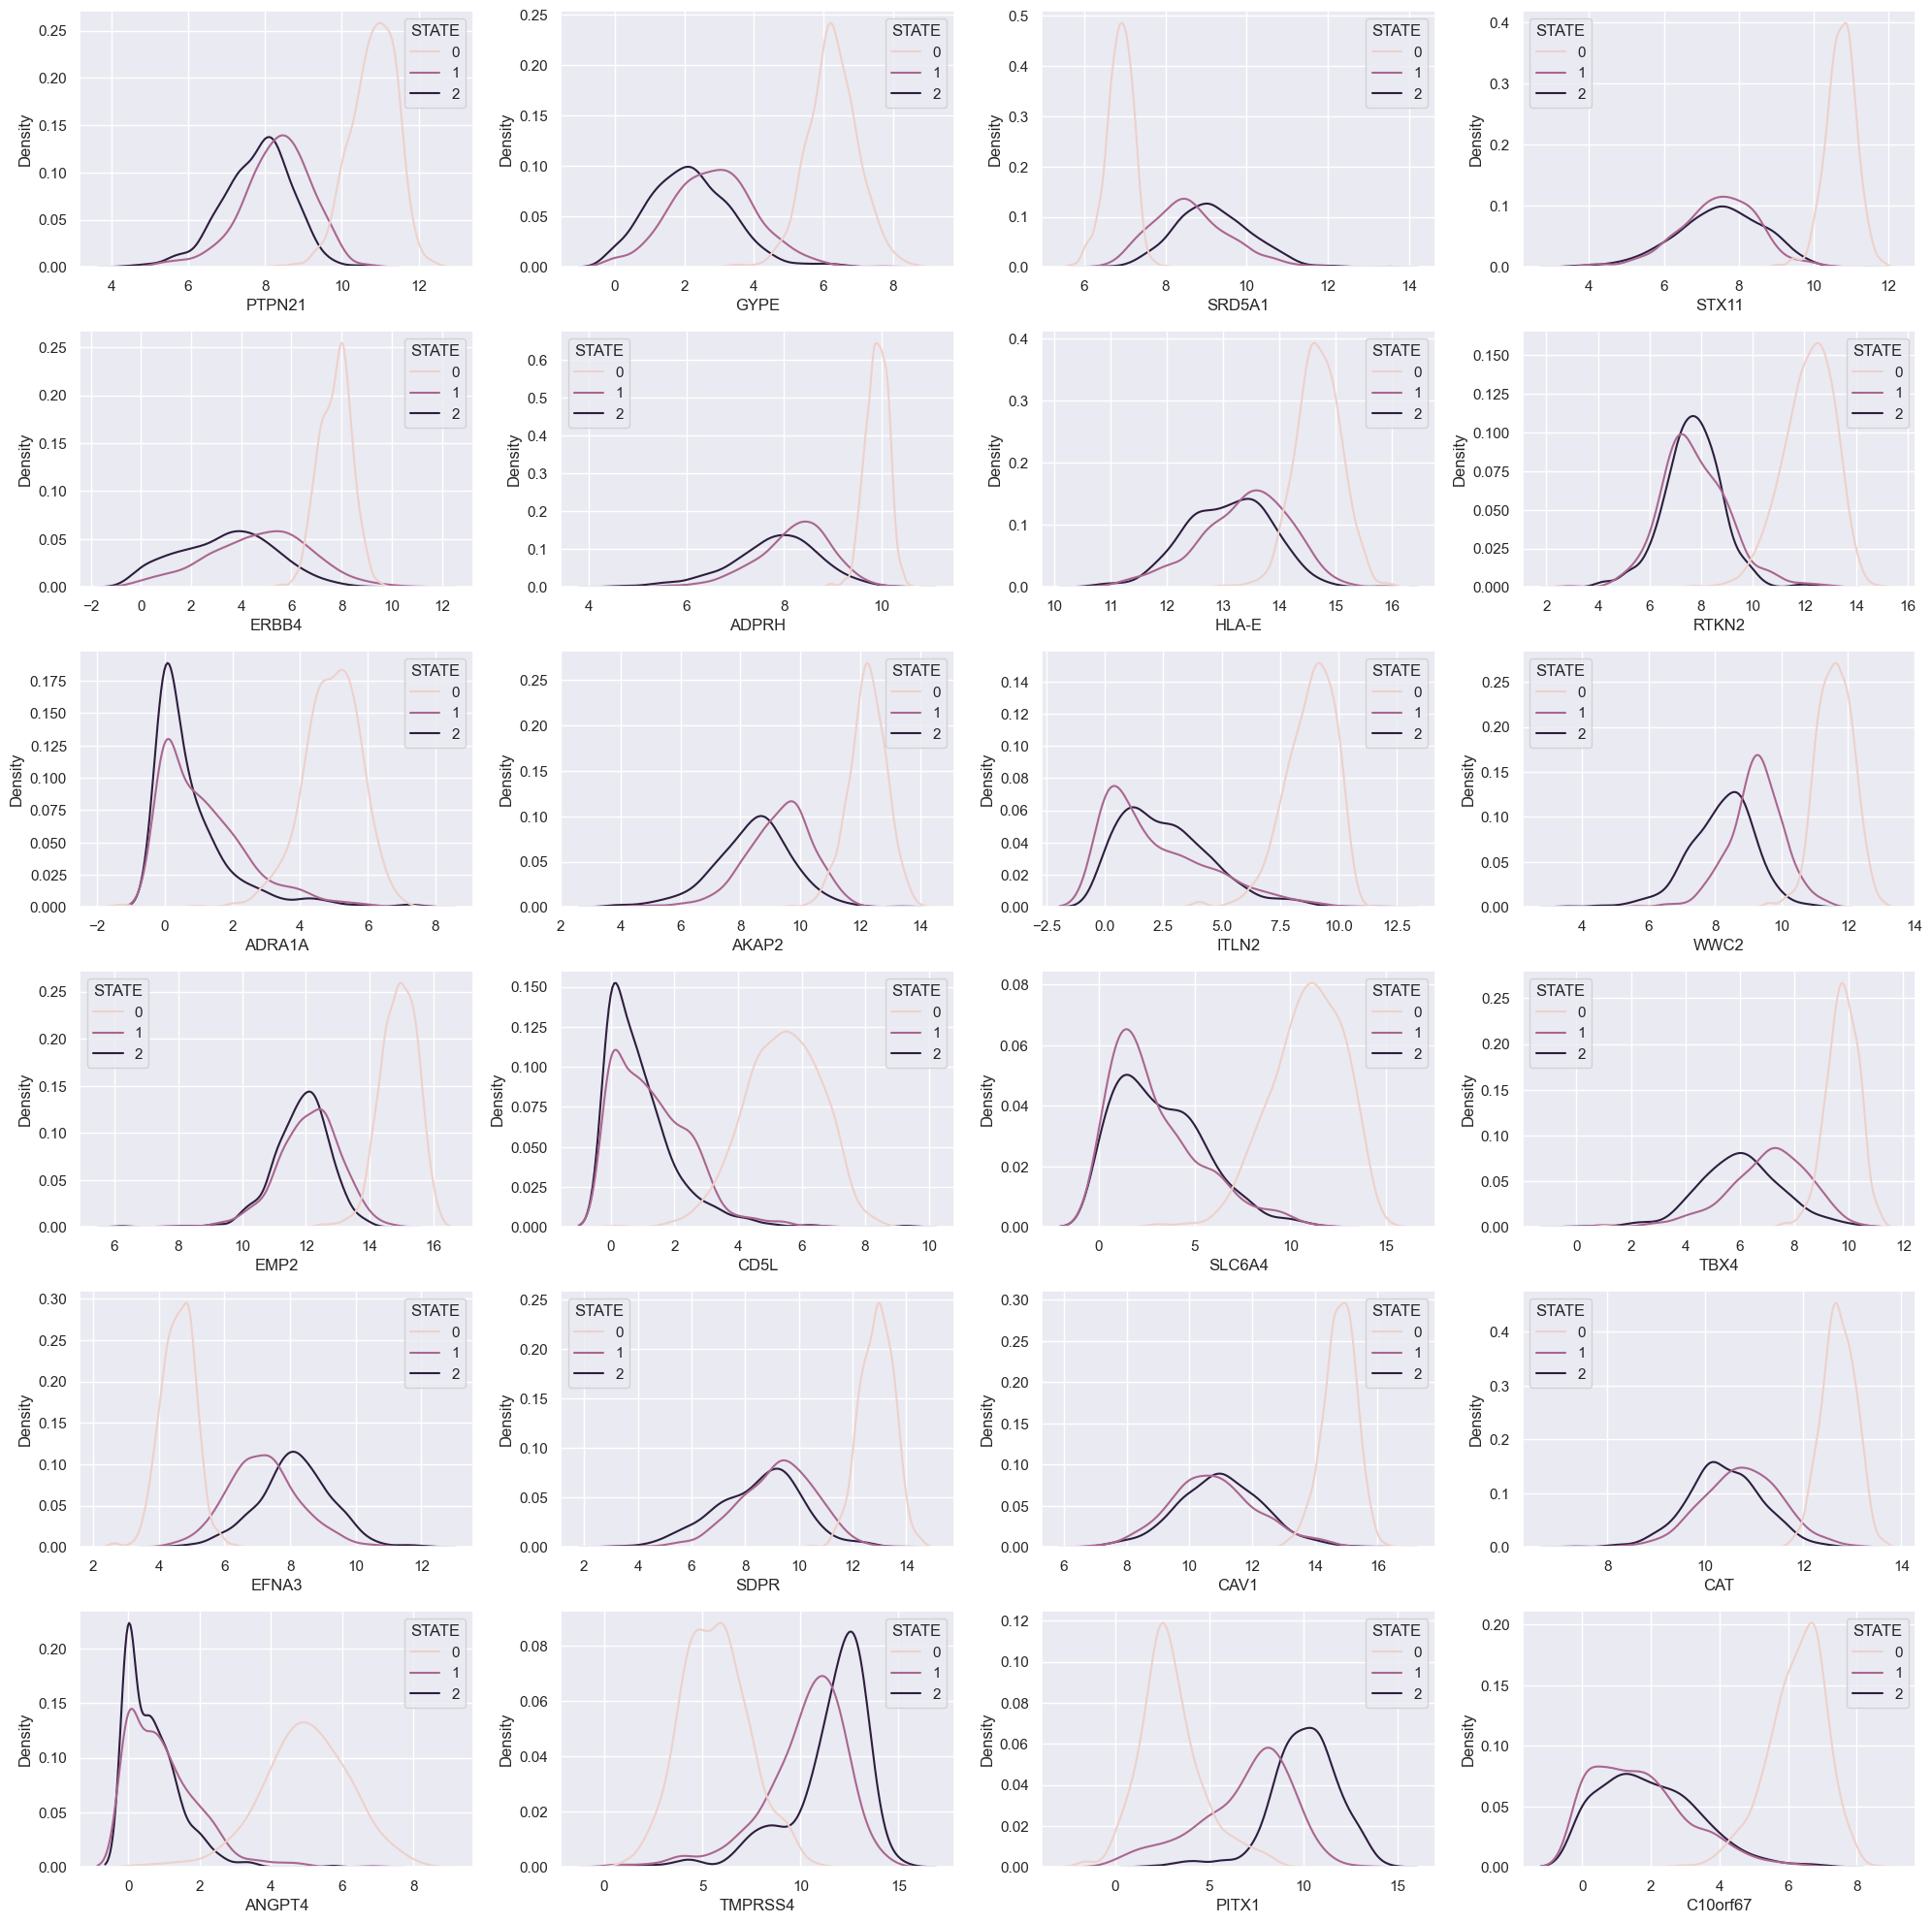

In [71]:
fig, axs = plt.subplots(6, 4, figsize=(20, 20))
i = 0
for gen in best_standard_norm_tumor:
    sns.kdeplot(data=df, x=gen, hue='STATE', ax=axs[i // 4, i % 4], legend=True)
    i += 1
plt.tight_layout();

In [72]:
fig.savefig('Compare_Standard_norm_tumor.svg', format='svg')

#### ***Detecting AC_SCC***

In [12]:
X_AC_SCC = df[df.STATE != 0] #(1018, 16739)
X_AC_SCC.drop(constant_gens + list(corr_features) + ['STATE'], axis=1, inplace=True) # (1018, 16739)
y_AC_SCC = df.STATE[df.STATE != 0] # (1018,)
X_AC_SCC.shape # (1018, 16739)

(1018, 16739)

In [13]:
from sklearn.feature_selection import mutual_info_classif, SelectKBest
mutual_info = pd.Series(mutual_info_classif(X_AC_SCC, y_AC_SCC))
mutual_info.index = X_AC_SCC.columns
best10_MI_AC_SCC = mutual_info.sort_values(ascending=False).head(10).index
best10_MI_AC_SCC

Index(['DSG3', 'KRT74', 'DSC3', 'S1PR5', 'TP63', 'CALML3', 'IRF6', 'BNC1',
       'FAT2', 'CSTA'],
      dtype='object')

In [14]:
from sklearn.feature_selection import f_classif
sel_10_cols = SelectKBest(f_classif, k=10)
sel_10_cols.fit(X_AC_SCC, y_AC_SCC)
best10_ANOVA_AC_SCC = X_AC_SCC.columns[sel_10_cols.get_support()]
best10_ANOVA_AC_SCC

Index(['BNC1', 'CALML3', 'CLCA2', 'DSC3', 'DSG3', 'FAT2', 'KRT6A', 'KRT74',
       'S1PR5', 'TP63'],
      dtype='object')

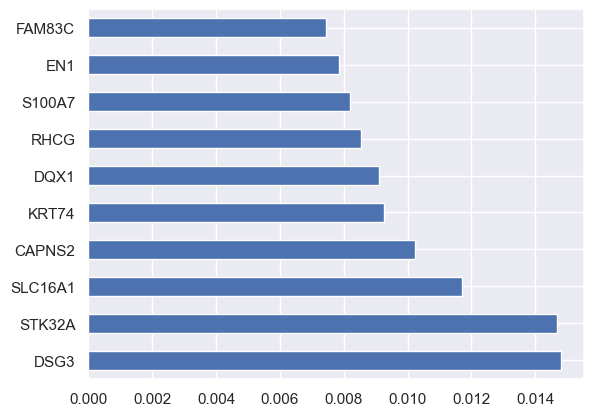

In [83]:
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier(random_state=3)
model.fit(X_AC_SCC, y_AC_SCC)
ranked_features = pd.Series(model.feature_importances_, index=X_AC_SCC.columns)
best10_TreesClass_AC_SCC = list(ranked_features.nlargest(10).index)
ranked_features.nlargest(10).plot(kind='barh');

In [85]:
best_standard_AC_SCC = list(set(best10_MI_AC_SCC) | set(best10_ANOVA_AC_SCC) | set(best10_TreesClass_AC_SCC)) # 19
len(best_standard_AC_SCC)

20

In [86]:
with open('best_standard_AC_SCC.pkl', 'wb') as file:
    pickle.dump(best_standard_AC_SCC, file)

In [87]:
df_ = df.loc[:, best_standard_AC_SCC + ['STATE']] # (1706, 20)
df_.shape # (1706, 20)

(1706, 21)

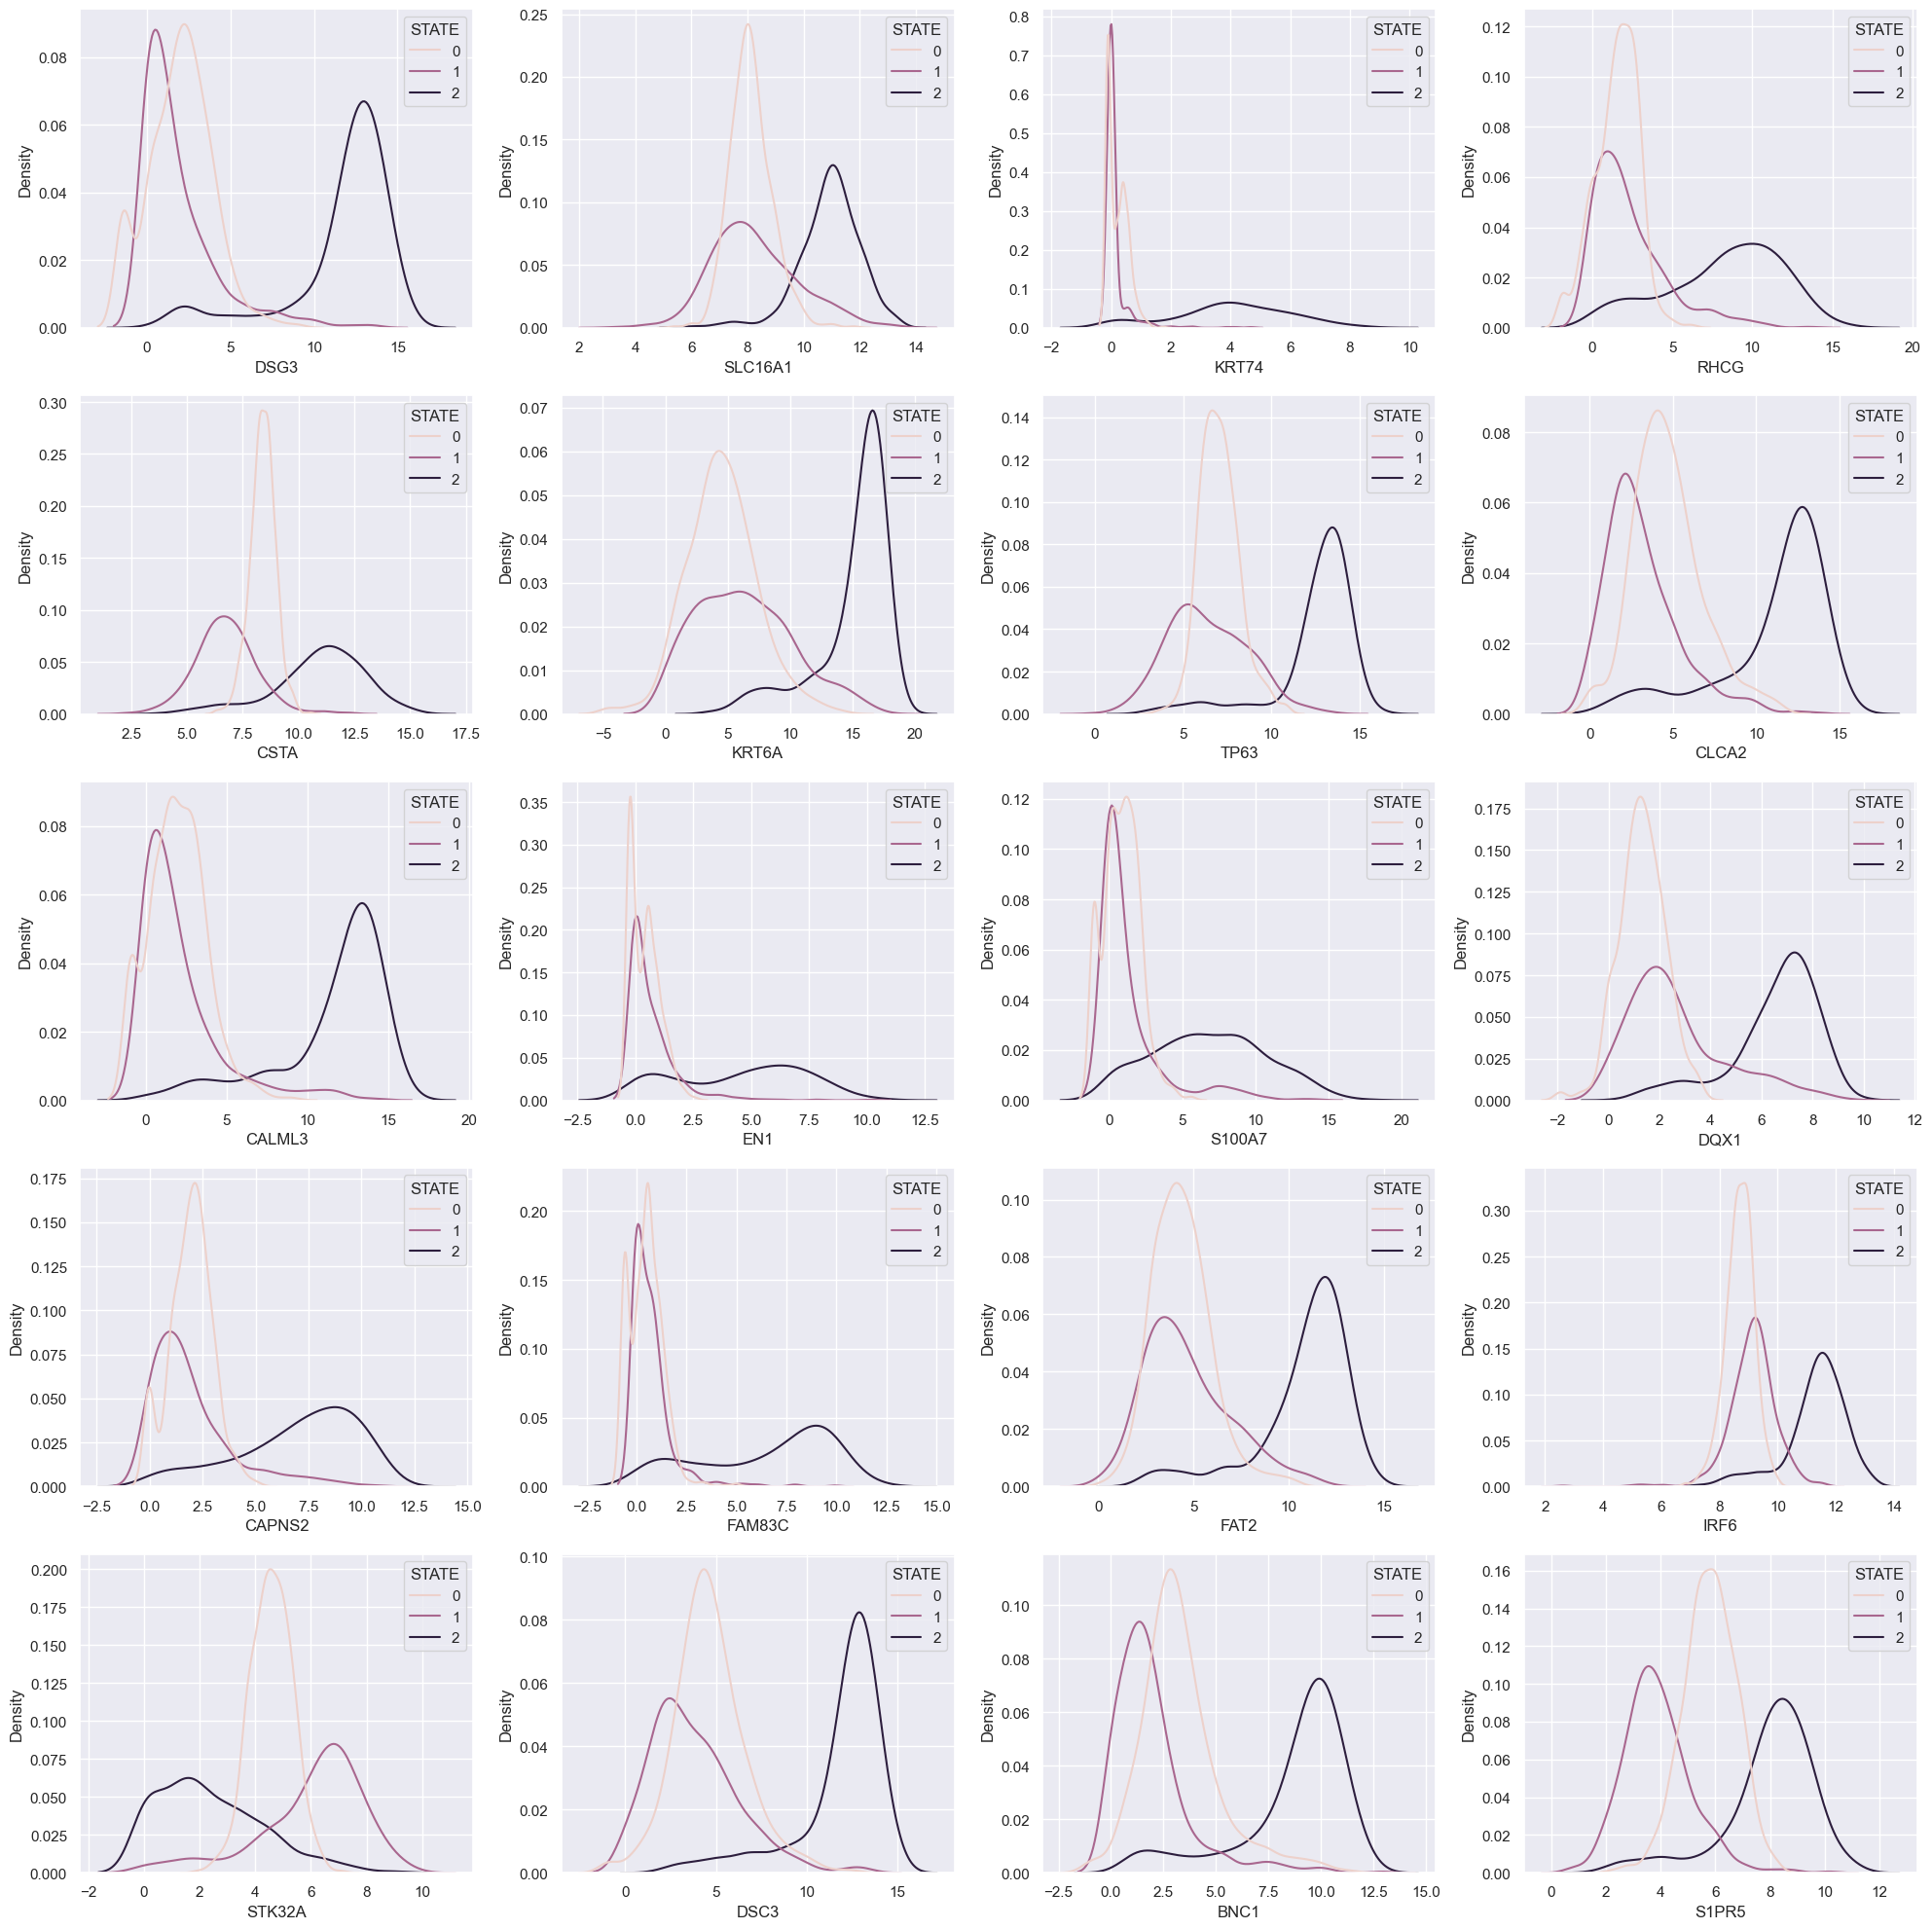

In [88]:
X_ = df.loc[:, ]
fig, axs = plt.subplots(5, 4, figsize=(20, 20))
i = 0
for gen in best_standard_AC_SCC:
    sns.kdeplot(data=df_, x=gen, hue='STATE', ax=axs[i // 4, i % 4], legend=True)
    i += 1
plt.tight_layout();

In [89]:
fig.savefig('Compare_Standard_AC_SCC.svg', format='svg')

### 6. Specific Bioinformatic's Laboratory Technique

**Detecting ONLY tumor**

In [28]:
auc_sample = {}
for gen in X.columns:
    trainX, testX, trainY, testY = train_test_split(X.loc[:, gen], y_norm_tumor, test_size=0.3, random_state=1)
    trainX = trainX.to_numpy().reshape(-1, 1)
    testX = testX.to_numpy().reshape(-1, 1)
    model = LogisticRegression().fit(trainX, trainY)
    probs = model.predict_proba(testX)
    res_probs = probs[:, 1]
    auc_sample[gen] = roc_auc_score(testY, res_probs)
#print('Logistic: ROC AUC=%.3f' % (res_auc))
auc_norm_tumor = pd.DataFrame.from_dict(auc_sample, orient='index', columns=['norm_tumor'])
auc_norm_tumor.sort_values(by='norm_tumor', ascending=False).head(15)

,norm_tumor
SDPR,0.997363
WWC2,0.996621
STX11,0.996494
EMP2,0.995879
AKAP2,0.994757
PTPN21,0.994742
ADRB2,0.994726
EFNA3,0.993936
CAV1,0.993620
PAICS,0.993463


In [94]:
set(auc_norm_tumor.sort_values(by='norm_tumor', ascending=False).head(30).index) & set(best_standard_norm_tumor)
# {'AKAP2', 'CAT', 'CAV1', 'EFNA3', 'EMP2', 'GYPE', 'PTPN21', 'RTKN2', 'SDPR', 'STX11', 'WWC2'} 11 common best features

{'AKAP2',
 'CAT',
 'CAV1',
 'EFNA3',
 'EMP2',
 'GYPE',
 'PTPN21',
 'RTKN2',
 'SDPR',
 'STX11',
 'WWC2'}

**Detecting AC SCC**

In [95]:
auc_sample = {}
for gen in X_AC_SCC.columns:
    trainX, testX, trainY, testY = train_test_split(X_AC_SCC.loc[:, gen], y_AC_SCC, test_size=0.3, random_state=1)
    trainX = trainX.to_numpy().reshape(-1, 1)
    testX = testX.to_numpy().reshape(-1, 1)
    model = LogisticRegression().fit(trainX, trainY)
    probs = model.predict_proba(testX)
    res_probs = probs[:, 1]
    auc_sample[gen] = roc_auc_score(testY, res_probs)
auc_AC_SCC = pd.DataFrame.from_dict(auc_sample, orient='index', columns=['AC_SCC'])
auc_AC_SCC.sort_values(by='AC_SCC', ascending=False).head(15)

,AC_SCC
HNF1B,0.976068
CALML3,0.970983
DSC3,0.970897
DDAH1,0.967436
RBM47,0.965897
DSG3,0.964872
ARHGEF38,0.964615
KRT74,0.962585
AP2M1,0.962393
TP63,0.962350


In [96]:
set(auc_AC_SCC.sort_values(by='AC_SCC', ascending=False).head(30).index) & set(best_standard_AC_SCC)
# {'BNC1', 'CALML3', 'CLCA2', 'DSC3', 'DSG3', 'FAT2', 'KRT6A', 'KRT74', 'S1PR5','TP63'} 10 common best features

{'BNC1',
 'CALML3',
 'CLCA2',
 'DSC3',
 'DSG3',
 'FAT2',
 'KRT6A',
 'KRT74',
 'S1PR5',
 'TP63'}

In [97]:
from sklearn.feature_selection import f_classif
f_vales, p_values = f_classif(df.iloc[:, :-1], y_norm_tumor)
p_value_norm_tumor = pd.Series(p_values, index=df.columns[:-1])
f_vales_, p_values_ = f_classif(X_AC_SCC, y_AC_SCC)
p_value_AC_SCC = pd.Series(p_values_, index=X_AC_SCC.columns)

In [98]:
auc_pvalue = pd.concat([auc_norm_tumor, auc_AC_SCC, p_value_norm_tumor, p_value_AC_SCC], axis=1)
auc_pvalue.columns = ['auc_norm_tumor', 'auc_AC_SCC', 'p_value_norm_tumor', 'p_value_AC_SCC']
auc_pvalue.head() # (17593, 4)

,auc_norm_tumor,auc_AC_SCC,p_value_norm_tumor,p_value_AC_SCC
A1BG,0.548171,0.561624,3.041938e-02,1.039278e-02
A1CF,0.494623,0.567585,2.156998e-10,6.663154e-08
A2M,0.985077,0.820085,0.000000e+00,7.167148e-59
A2ML1,0.759392,0.918739,6.929471e-106,1.291131e-187
A4GALT,0.600139,0.837906,4.067414e-10,1.411739e-71


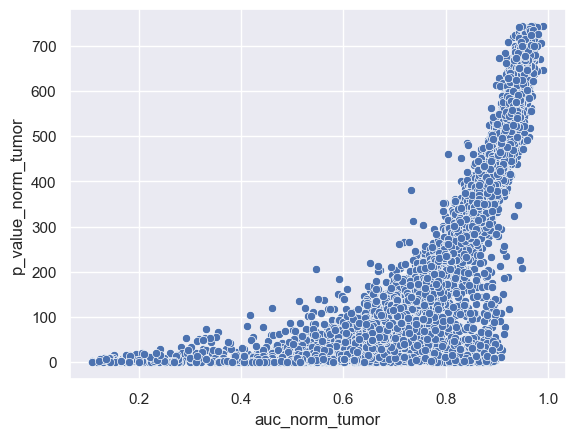

In [100]:
y1 = np.log(auc_pvalue.p_value_norm_tumor)
sns.scatterplot(data=auc_pvalue, x='auc_norm_tumor', y=-y1);
plt.savefig('auc_norm_tumor.svg', format='svg')

In [109]:
best_auc_norm_tumor = auc_pvalue[(-np.log(auc_pvalue.p_value_norm_tumor) > 650) & (auc_pvalue.auc_norm_tumor > 0.99)]
best_auc_norm_tumor = list(best_auc_norm_tumor.index)
final_norm_tumor = list(set(best_auc_norm_tumor) & set(best_standard_norm_tumor)) # 10
union_norm_tumor = list(set(set(best_auc_norm_tumor) | set(best_standard_norm_tumor))) # 40
len(union_norm_tumor)

40

In [111]:
pickle.dump(final_norm_tumor, open('Bio_final_norm_tumor.pkl', 'wb'))
pickle.dump(union_norm_tumor, open('Bio_union_norm_tumor.pkl', 'wb'))

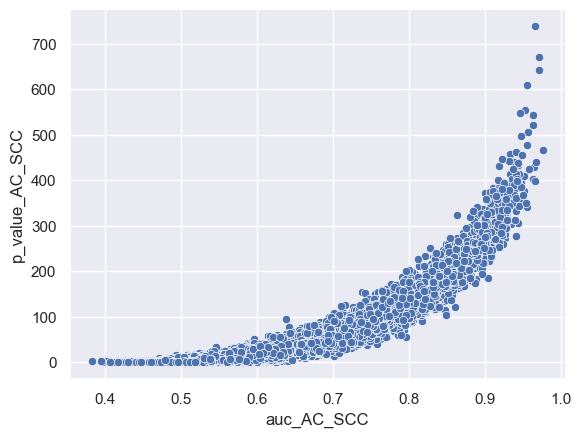

In [112]:
y1 = np.log(auc_pvalue.p_value_AC_SCC)
sns.scatterplot(data=auc_pvalue, x='auc_AC_SCC', y=-y1);
plt.savefig('auc_AC_SCC.svg', format='svg')

In [123]:
df_best_AC_SCC = auc_pvalue[(-np.log(auc_pvalue.p_value_AC_SCC) > 430) & (auc_pvalue.auc_AC_SCC > 0.925)]
best_auc_AC_SCC = list(df_best_AC_SCC.index) # 15
len(best_auc_AC_SCC)

24

In [125]:
final_AC_SCC = set(best_standard_AC_SCC) & set(best_auc_AC_SCC) # 12
union_AC_SCC = set(set(best_standard_AC_SCC) | set(best_auc_AC_SCC)) # 32
len(union_AC_SCC), len(final_AC_SCC)

(32, 12)

In [126]:
pickle.dump(final_AC_SCC, open('Bio_final_AC_SCC.pkl', 'wb'))
pickle.dump(union_AC_SCC, open('Bio_union_AC_SCC.pkl', 'wb'))